## load data

In [1]:
import pandas as pd

df = pd.read_csv('data/train_data.csv')
print(df.shape)
df.head()

(2848, 2)


,file_name,question
0,05x10x00x00F001962766N0073.png,what's left
1,10x25x50x10F001242790N0038.png,how many beds are in the room
2,10x25x20x05F000457465N0004.png,what is the color of ceiling light bulbs
3,05x10x50x10F000391480N0099.png,where this corridor leading
4,05x10x00x00F000148666N0083.png,what is on the picture


In [2]:
questions = df.question.tolist()
questions[:5]

["what's left",
 'how many beds are in the room',
 'what is the color of ceiling light bulbs',
 'where this corridor leading',
 'what is on the picture']

In [3]:
answers = [x.strip() for x in open('data/train_answers.csv').readlines()[1:]]
answers_unique = list(set(answers))
answers_unique[:5]

['4', 'gray', 'column', 'chair with umbrella', 'kitchen']

In [4]:
paths = df.file_name.tolist()
paths[:5]

['05x10x00x00F001962766N0073.png',
 '10x25x50x10F001242790N0038.png',
 '10x25x20x05F000457465N0004.png',
 '05x10x50x10F000391480N0099.png',
 '05x10x00x00F000148666N0083.png']

In [5]:
from PIL import Image
import os

images = [Image.open(os.path.join('data', 'train_images', p)) for p in paths]

## load test data

In [6]:
import pandas as pd

df_test = pd.read_csv('data/test_data.csv')
print(df_test.shape)
df_test.head()

(600, 2)


,file_name,question
0,05x10x20x05F002543965N0226.png,what is there on the right side of the table
1,05x10x20x05F000898640N0064.png,what is on the wall
2,10x25x50x10F002012767N0041.png,what color is the cabinet
3,05x10x20x05F001658019N0018.png,who is on the painting
4,05x10x50x10F002543961N0151.png,what color are the walls


In [7]:
questions_test = df_test.question.tolist()
questions_test[:5]

['what is there on the right side of the table',
 'what is on the wall',
 'what color is the cabinet',
 'who is on the painting',
 'what color are the walls']

In [8]:
paths_test = df_test.file_name.tolist()
paths_test[:5]

['05x10x20x05F002543965N0226.png',
 '05x10x20x05F000898640N0064.png',
 '10x25x50x10F002012767N0041.png',
 '05x10x20x05F001658019N0018.png',
 '05x10x50x10F002543961N0151.png']

In [9]:
len(paths_test)

600

In [10]:
images_test = [Image.open(os.path.join('data', 'test_images', p)) for p in paths_test]

## make splits

In [11]:
import random
import os

indices = list(range(len(questions)))
random.seed(0)
random.shuffle(indices)

val_size = 600
val_indices = indices[:val_size]
train_indices = indices[val_size:]

train = {
    'q': [questions[i] for i in train_indices],
    'a': [answers_unique.index(answers[i]) for i in train_indices],
    'p': [os.path.join('data', 'train_images', paths[i]) for i in train_indices],
}

val = {
    'q': [questions[i] for i in val_indices],
    'a': [answers_unique.index(answers[i]) for i in val_indices],
    'p': [os.path.join('data', 'train_images', paths[i]) for i in val_indices],
}

test = {
    'q': questions_test,
    'p': [os.path.join('data', 'test_images', paths_test[i]) for i in range(len(paths_test))],
}

In [12]:
import json

json.dump(train, open('data/my_splits/train.json', 'w'))
json.dump(val, open('data/my_splits/val.json', 'w'))
json.dump(test, open('data/my_splits/test.json', 'w'))
json.dump(answers_unique, open('data/my_splits/answers_unique.json', 'w'))

## analize

In [15]:
import matplotlib.pyplot as plt

def show(i, images, questions, answers):    
    print('Q:', questions[i])
    print('A:', answers[i])

    plt.imshow(images[i])
    plt.axis('off')

Q: how many doors are there in the picture
A: 1


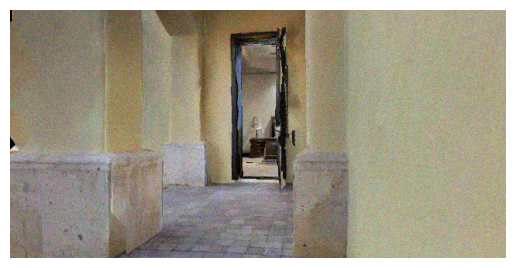

In [16]:
show(8, images, questions, answers)

In [17]:
import numpy as np

len(np.unique(answers)), len(np.unique(questions)), len(questions)

(461, 2010, 2848)

## dataset

In [2]:
from src.dataset import VQADataset

dataset = VQADataset('data/my_splits/train.json')
len(dataset)

2247

In [7]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    q_list, a_list, p_list = [], [], []
    for q, a, p in batch:
        q_list.append(q)
        a_list.append(a)
        p_list.append(p)
    return q_list, a_list, p_list

loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

In [8]:
next(iter(loader))

(['how many bed is here',
  'what element can be found on the top left',
  'how many pillars are there',
  'what is the color of the chairs'],
 ['1', 'ceiling', '2', 'white'],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x320>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x320>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x320>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x320>])

## submission

### load weights

In [1]:
from src.learner import Learner, LearnerConfig
from src.models import get_clip

clip, processor = get_clip()
model = Learner.load_from_checkpoint(
    checkpoint_path='logs/tb/clip-clf-large/version_1/checkpoints/epoch=9-step=350.ckpt',
    model=clip,
    processor=processor,
    config=LearnerConfig()
)

/home/ilya/repos/dl-masters/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### load test data

In [8]:
from src.dataset import VQADataset
from torch.utils.data import DataLoader

test_dataset = VQADataset(path='data/my_splits/test.json', test=True)
train_dataset = VQADataset(path='data/my_splits/train.json')
print(len(test_dataset))

def collate_fn(batch):
    q_list, p_list = [], []
    for q, p in batch:
        q_list.append(q)
        p_list.append(p)
    return q_list, p_list

def collate_fn_tr(batch):
    q_list, a_list, p_list = [], [], []
    for q, a, p in batch:
        q_list.append(q)
        a_list.append(a)
        p_list.append(p)
    return q_list, a_list, p_list

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn_tr
)

600


### infere qi test

In [3]:
import torch
model.eval()

all_qi_embeddings = []
with torch.no_grad():
    for batch in test_loader:
        questions, images = batch
        qi_embeddings = model.get_qi_embeddings(questions, images)
        all_qi_embeddings.append(qi_embeddings.cpu())

qi_embeddings = torch.cat(all_qi_embeddings, dim=0)
qi_embeddings.shape

torch.Size([600, 768])

### infere qi train

In [11]:
import torch
model.eval()
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

all_qi_embeddings_tr = []
all_answers = []
with torch.no_grad():
    for batch in train_loader:
        questions, answers, images = batch
        all_answers.extend(answers)
        qi_embeddings = model.get_qi_embeddings(questions, images)
        all_qi_embeddings_tr.append(qi_embeddings.cpu())

qi_embeddings_tr = torch.cat(all_qi_embeddings_tr, dim=0)
qi_embeddings_tr.shape

torch.Size([2248, 768])

### infere a

In [4]:
import json
answers_unique = json.load(open('data/my_splits/answers_unique.json', 'r'))

In [5]:
batch_size = 32

all_a_embeddings = []
with torch.no_grad():
    for i in range(0, len(answers_unique), batch_size):
        a = answers_unique[i:i+batch_size]
        a_embeddings = model.get_a_embeddings(a)
        all_a_embeddings.append(a_embeddings.cpu())

a_embeddings = torch.cat(all_a_embeddings, dim=0)
a_embeddings.shape

AttributeError: 'Learner' object has no attribute 'a_projector'

### vector search

In [18]:
similarities = qi_embeddings @ a_embeddings.T

pred_ans_inds = similarities.argmax(dim=1)
pred_ans_inds.shape

torch.Size([600])

In [20]:
pred_ans = [answers_unique[i] for i in pred_ans_inds]
pred_ans[:5]

['cart', 'tv', 'purple', 'above', 'white']

In [21]:
pd.DataFrame(pred_ans).to_csv('data/subm-3.csv', index=False, header=False)

### classification linear

In [4]:
with torch.no_grad():
    # for q in qi_embeddings:
    pred = model.clf(qi_embeddings.cuda()).argmax(dim=1).cpu()

pred.shape

torch.Size([600])

In [5]:
import json
answers_unique = json.load(open('data/my_splits/answers_unique.json', 'r'))

pred_ans = [answers_unique[i] for i in pred]
pred_ans[:5]

['chair', 'picture', 'white', 'yes', 'white']

In [6]:
import pandas as pd
pd.DataFrame(pred_ans).to_csv('data/subm-9.csv', index=False, header=False)